In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.io import loadmat 
import pickle 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
# load choice matrices 
cmats = loadmat('datasets/human_choices.mat')

Text(0.5, 1.0, 'Interleaved - Task B')

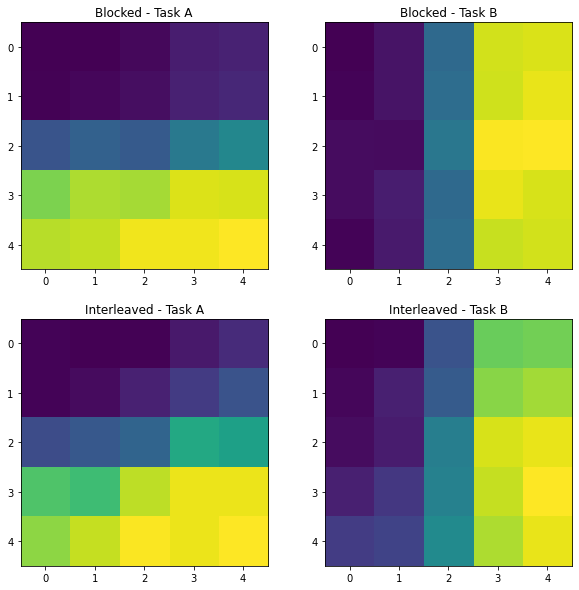

In [3]:
cmats.keys()
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(cmats['cmat_b_north'].mean(0))
plt.title('Blocked - Task A')

plt.subplot(2,2,2)
plt.imshow(cmats['cmat_b_south'].mean(0))
plt.title('Blocked - Task B')

plt.subplot(2,2,3)
plt.imshow(cmats['cmat_i_north'].mean(0))
plt.title('Interleaved - Task A')

plt.subplot(2,2,4)
plt.imshow(cmats['cmat_i_south'].mean(0))
plt.title('Interleaved - Task B')


In [84]:
# load sluggish net results 
with open('fit_sluggishness_results.pkl','rb') as f:
    results = pickle.load(f)

In [93]:
corrs = []
outputs = []
for r in results:

    corrs.append(r[2:4])
    outputs.append(r[4])
corrs = np.array(corrs)

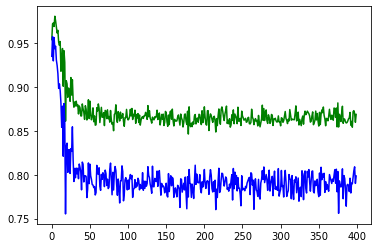

In [100]:
%matplotlib qt
plt.plot(corrs[:,1],'g-')
plt.plot(corrs[:,0],'b-')

In [102]:
outputs[0]

(50,)

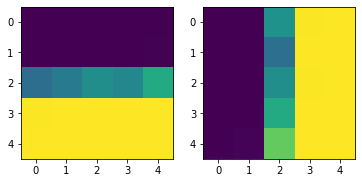

In [103]:
%matplotlib inline
choices = outputs[0]
f,ax = plt.subplots(1,2)
ax = ax.ravel()
ax[0].imshow(choices[:25].reshape(5,5))
ax[1].imshow(choices[25:].reshape(5,5))

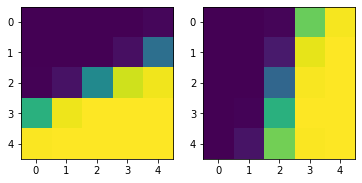

In [106]:
choices = outputs[5]
f,ax = plt.subplots(1,2)
ax = ax.ravel()
ax[0].imshow(choices[:25].reshape(5,5))
ax[1].imshow(choices[25:].reshape(5,5))